## Sentiment Analysis of the IMDB Dataset using Keras

In [1]:

import os
import tqdm
import codecs
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Conv1D, Dense, Embedding, Flatten, Input, LSTM, MaxPooling1D, Dropout, concatenate, BatchNormalization, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
import matplotlib.pyplot as plt



c:\users\lord sanmilee\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\lord sanmilee\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
c:\users\lord sanmilee\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:
# Load the imdb data
positive_dir = "aclImdb/train/pos"
negative_dir = "aclImdb/train/neg"


In [3]:
# Data Pre-processing
def read_text(filename):
    with codecs.open(filename, encoding='utf8') as f:
            return f.read().lower()

print ("Reading negative reviews.")
negative_text = [read_text(os.path.join(negative_dir, filename))
        for filename in tqdm.tqdm(os.listdir(negative_dir))]
        
print ("Reading positive reviews.")
positive_text = [read_text(os.path.join(positive_dir, filename))
        for filename in tqdm.tqdm(os.listdir(positive_dir))]



Reading negative reviews.


100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 11445.72it/s]


Reading positive reviews.


100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 11352.74it/s]


In [4]:
# declaration of variables
MAX_NB_WORDS = 25000
MAX_SEQUENCE_LENGTH = 200 # 500
N_GLOVE_TOKENS = 400000
EMBEDDING_DIM = 100


In [5]:

labels_index = { "negative": 0, "positive": 1 }

labels = [0 for _ in range(len(negative_text))] + \
        [1 for _ in range(len(negative_text))]
 
texts = negative_text + positive_text


In [6]:
# Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index


In [7]:
# Data Padding
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np_utils.to_categorical(np.asarray(labels))
print ("data.shape = {0}, labels.shape = {1}".format(data.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(data, labels)



data.shape = (25000, 200), labels.shape = (25000, 2)


In [8]:
# Load word embeddings

print("Loading word embeddings.")
embeddings_index = dict()
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in tqdm.tqdm(f, total=N_GLOVE_TOKENS):
        values = line.split()
        word, coefficients = values[0], np.asarray(values[1:], dtype=np.float32)
        embeddings_index[word] = coefficients
                       
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
print ("embedding_matrix.shape = {0}".format(embedding_matrix.shape))

# Embedding Layer
embedding_layer = Embedding(len(word_index)+1,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
embedded_sequences = embedding_layer(sequence_input)
print (embedded_sequences.shape )
     

Loading word embeddings.


100%|███████████████████████████████████████████████████████████████████████| 400000/400000 [00:10<00:00, 38635.31it/s]


embedding_matrix.shape = (88583, 100)
(?, 200, 100)


In [9]:
# model design

input_layer = Conv1D(8, 1, activation="relu")(embedded_sequences)

dropout_layer = Dropout(0.3)(input_layer)
normalization_layer = BatchNormalization()(dropout_layer)
lstm_layer = Bidirectional(LSTM(8, dropout=0.2, recurrent_dropout=0.2))(normalization_layer)
dense_layer = Dense(8, activation="relu")(lstm_layer)
output_layer = Dense(len(labels_index), activation="softmax")(dense_layer)

model = Model(sequence_input, output_layer)

print(model.summary())

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["acc"])



(?, 8) 
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          8858300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 8)            808       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 8)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 8)            32        
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       

In [10]:
# Training

history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=3, batch_size=64)


score = model.evaluate(x_test, y_test, verbose=0)


Train on 18750 samples, validate on 6250 samples
Epoch 1/3


13056/18750 [===================>..........] - ETA: 7:02 - loss: 0.6817 - acc: 0.593 - ETA: 4:43 - loss: 0.6917 - acc: 0.531 - ETA: 3:55 - loss: 0.7023 - acc: 0.520 - ETA: 3:34 - loss: 0.7101 - acc: 0.507 - ETA: 3:20 - loss: 0.7076 - acc: 0.521 - ETA: 3:09 - loss: 0.7104 - acc: 0.520 - ETA: 3:01 - loss: 0.7106 - acc: 0.517 - ETA: 2:59 - loss: 0.7071 - acc: 0.527 - ETA: 2:55 - loss: 0.7121 - acc: 0.513 - ETA: 2:51 - loss: 0.7120 - acc: 0.512 - ETA: 2:48 - loss: 0.7141 - acc: 0.505 - ETA: 2:45 - loss: 0.7144 - acc: 0.501 - ETA: 2:43 - loss: 0.7124 - acc: 0.501 - ETA: 2:40 - loss: 0.7142 - acc: 0.497 - ETA: 2:38 - loss: 0.7115 - acc: 0.501 - ETA: 2:36 - loss: 0.7111 - acc: 0.501 - ETA: 2:35 - loss: 0.7112 - acc: 0.502 - ETA: 2:33 - loss: 0.7133 - acc: 0.496 - ETA: 2:32 - loss: 0.7116 - acc: 0.499 - ETA: 2:31 - loss: 0.7099 - acc: 0.501 - ETA: 2:29 - loss: 0.7100 - acc: 0.500 - ETA: 2:29 - loss: 0.7097 - acc: 0.497 - ETA: 2:28 - loss: 0.7108 - acc: 0.494 - ETA: 2:27 - loss: 0.7103 - acc: 0

13120/18750 [===================>..........] - ETA: 2:32 - loss: 0.6931 - acc: 0.500 - ETA: 2:30 - loss: 0.6802 - acc: 0.562 - ETA: 2:32 - loss: 0.6869 - acc: 0.531 - ETA: 2:31 - loss: 0.6876 - acc: 0.527 - ETA: 2:30 - loss: 0.6902 - acc: 0.518 - ETA: 2:31 - loss: 0.6926 - acc: 0.515 - ETA: 2:30 - loss: 0.6894 - acc: 0.524 - ETA: 2:30 - loss: 0.6867 - acc: 0.539 - ETA: 2:30 - loss: 0.6866 - acc: 0.545 - ETA: 2:29 - loss: 0.6865 - acc: 0.545 - ETA: 2:28 - loss: 0.6844 - acc: 0.558 - ETA: 2:28 - loss: 0.6838 - acc: 0.561 - ETA: 2:29 - loss: 0.6846 - acc: 0.550 - ETA: 2:28 - loss: 0.6861 - acc: 0.541 - ETA: 2:27 - loss: 0.6844 - acc: 0.547 - ETA: 2:26 - loss: 0.6843 - acc: 0.546 - ETA: 2:26 - loss: 0.6845 - acc: 0.546 - ETA: 2:25 - loss: 0.6852 - acc: 0.546 - ETA: 2:24 - loss: 0.6854 - acc: 0.545 - ETA: 2:23 - loss: 0.6853 - acc: 0.546 - ETA: 2:22 - loss: 0.6845 - acc: 0.547 - ETA: 2:22 - loss: 0.6837 - acc: 0.550 - ETA: 2:21 - loss: 0.6841 - acc: 0.546 - ETA: 2:22 - loss: 0.6836 - acc: 0

18750/18750 [==============================] - ETA: 46s - loss: 0.6724 - acc: 0.58 - ETA: 45s - loss: 0.6721 - acc: 0.58 - ETA: 45s - loss: 0.6720 - acc: 0.58 - ETA: 44s - loss: 0.6718 - acc: 0.58 - ETA: 44s - loss: 0.6717 - acc: 0.58 - ETA: 43s - loss: 0.6718 - acc: 0.58 - ETA: 42s - loss: 0.6716 - acc: 0.58 - ETA: 42s - loss: 0.6714 - acc: 0.58 - ETA: 41s - loss: 0.6714 - acc: 0.58 - ETA: 41s - loss: 0.6712 - acc: 0.59 - ETA: 40s - loss: 0.6711 - acc: 0.59 - ETA: 40s - loss: 0.6710 - acc: 0.59 - ETA: 39s - loss: 0.6707 - acc: 0.59 - ETA: 39s - loss: 0.6705 - acc: 0.59 - ETA: 38s - loss: 0.6705 - acc: 0.59 - ETA: 38s - loss: 0.6703 - acc: 0.59 - ETA: 37s - loss: 0.6702 - acc: 0.59 - ETA: 37s - loss: 0.6700 - acc: 0.59 - ETA: 36s - loss: 0.6698 - acc: 0.59 - ETA: 35s - loss: 0.6698 - acc: 0.59 - ETA: 35s - loss: 0.6698 - acc: 0.59 - ETA: 34s - loss: 0.6695 - acc: 0.59 - ETA: 34s - loss: 0.6694 - acc: 0.59 - ETA: 33s - loss: 0.6694 - acc: 0.59 - ETA: 33s - loss: 0.6693 - acc: 0.59 - ETA

13184/18750 [====================>.........] - ETA: 2:26 - loss: 0.5597 - acc: 0.750 - ETA: 2:26 - loss: 0.5981 - acc: 0.703 - ETA: 2:25 - loss: 0.6231 - acc: 0.666 - ETA: 2:25 - loss: 0.6180 - acc: 0.660 - ETA: 2:26 - loss: 0.6146 - acc: 0.668 - ETA: 2:25 - loss: 0.6244 - acc: 0.664 - ETA: 2:25 - loss: 0.6118 - acc: 0.680 - ETA: 2:25 - loss: 0.6132 - acc: 0.675 - ETA: 2:24 - loss: 0.6151 - acc: 0.675 - ETA: 2:24 - loss: 0.6164 - acc: 0.671 - ETA: 2:23 - loss: 0.6123 - acc: 0.676 - ETA: 2:25 - loss: 0.6130 - acc: 0.670 - ETA: 2:24 - loss: 0.6160 - acc: 0.665 - ETA: 2:23 - loss: 0.6202 - acc: 0.659 - ETA: 2:23 - loss: 0.6190 - acc: 0.660 - ETA: 2:22 - loss: 0.6274 - acc: 0.651 - ETA: 2:21 - loss: 0.6318 - acc: 0.642 - ETA: 2:21 - loss: 0.6335 - acc: 0.642 - ETA: 2:20 - loss: 0.6356 - acc: 0.640 - ETA: 2:20 - loss: 0.6291 - acc: 0.646 - ETA: 2:19 - loss: 0.6273 - acc: 0.650 - ETA: 2:18 - loss: 0.6292 - acc: 0.648 - ETA: 2:18 - loss: 0.6296 - acc: 0.648 - ETA: 2:18 - loss: 0.6301 - acc: 0

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
test loss: 0.615054415397644
test acc: 0.672319999961853


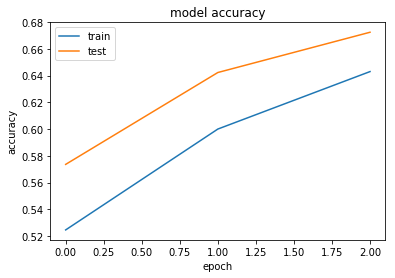

In [11]:
# training record

print(history.history.keys())
print('test loss:', score[0])
print('test acc:', score[1])


# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


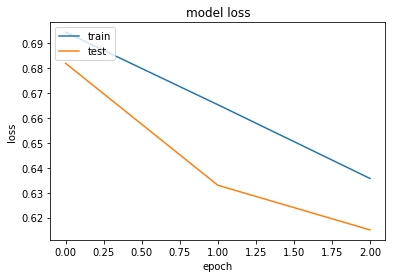

In [12]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
